In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.utils import image_dataset_from_directory

In [2]:
count = 0 
dirs = os.listdir('Images/')
for dir in dirs:
    files = list(os.listdir(f'Images/{dir}'))
    print(f'{dir} Folder has {len(files)} Images')
    count += len(files)
print(f'Images Folder has {count} Images')

Angelina Jolie Folder has 100 Images
Brad Pitt Folder has 100 Images
Hugh Jackman Folder has 100 Images
Johnny Depp Folder has 100 Images
Leonardo DiCaprio Folder has 100 Images
Images Folder has 500 Images


In [3]:
# Load datasets
base_dir = 'Images/'
img_size = 100
batch_size = 32

train_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='training',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)

val_ds = image_dataset_from_directory(
    base_dir,
    seed=123,
    validation_split=0.2,
    subset='validation',
    batch_size=batch_size,
    image_size=(img_size, img_size)
)


Found 500 files belonging to 5 classes.
Using 400 files for training.
Found 500 files belonging to 5 classes.
Using 100 files for validation.


In [4]:
class_names = train_ds.class_names

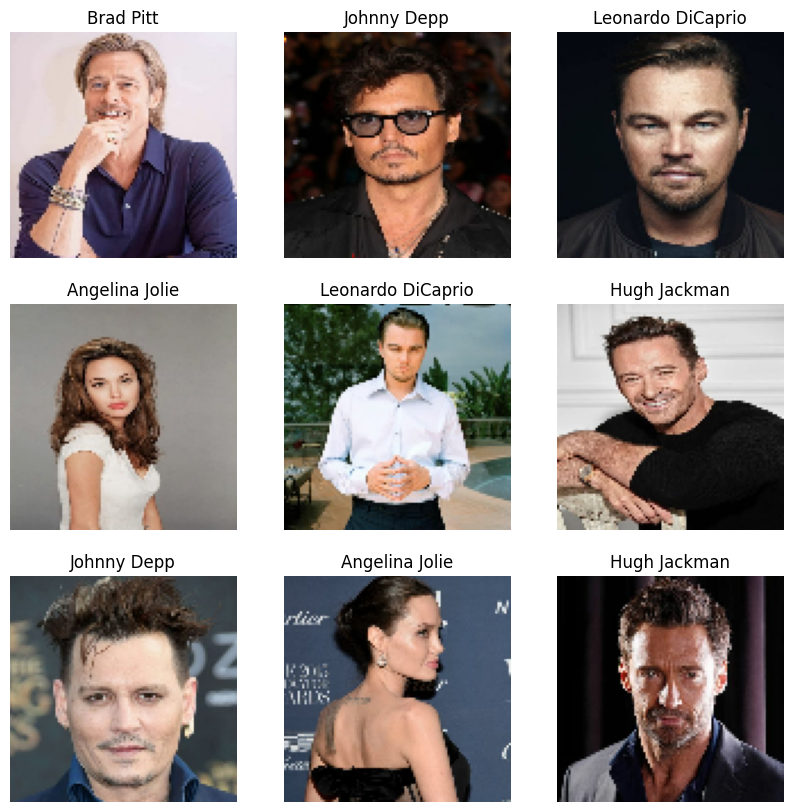

In [6]:
# Visualize a few images
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')
plt.show()

In [7]:
# Prefetch and cache data
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# Data augmentation
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1)
])

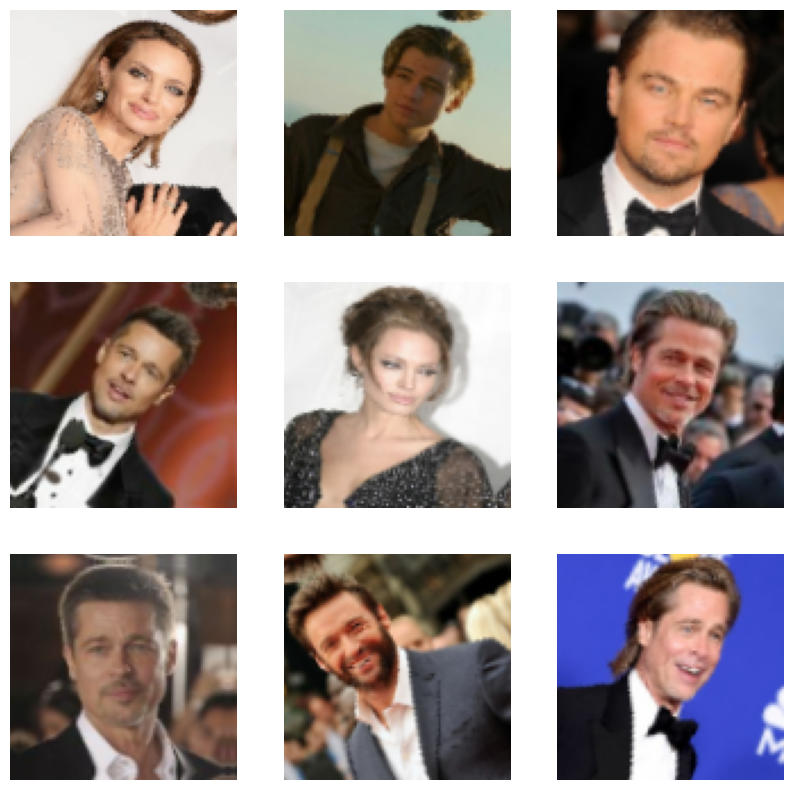

In [16]:
# Visualize augmented images
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    augmented_images = data_augmentation(images)
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype('uint8'))
        plt.axis('off')
plt.show()

In [17]:
# Build the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(len(class_names), activation='softmax')  # Number of classes should match the length of class_names
])

In [18]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',  # Use this for integer labels
              metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 98, 98, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 47, 47, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 23, 23, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 21, 21, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │       1,638,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,732,421 (6.61 MB)

 Trainable params: 1,732,421 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
print(f'Training dataset: {train_ds.cardinality().numpy()} batches')
print(f'Validation dataset: {val_ds.cardinality().numpy()} batches')

Training dataset: 13 batches
Validation dataset: 4 batches


In [21]:
history = model.fit(
    train_ds,
    epochs=15,
    validation_data=val_ds,
    verbose=1  # Increase verbosity for more detailed output
)

Epoch 1/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 218ms/step - accuracy: 0.2436 - loss: 99.0973 - val_accuracy: 0.1900 - val_loss: 2.4631
Epoch 2/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 173ms/step - accuracy: 0.2586 - loss: 1.9601 - val_accuracy: 0.2000 - val_loss: 1.5726
Epoch 3/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - accuracy: 0.5065 - loss: 1.3549 - val_accuracy: 0.2100 - val_loss: 1.7414
Epoch 4/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.5923 - loss: 1.0505 - val_accuracy: 0.2500 - val_loss: 2.1493
Epoch 5/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 185ms/step - accuracy: 0.7443 - loss: 0.6938 - val_accuracy: 0.2600 - val_loss: 2.4758
Epoch 6/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9326 - loss: 0.2655 - val_accuracy: 0.2200 - val_loss: 2.8615
Epoch 7/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.9742 - loss: 0.1678 - val_accuracy: 0.2400 - val_loss: 3.8389
Epoch 8/15
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.9882 - loss: 0.0742 - val_accuracy: 0

In [22]:
for images, labels in train_ds.take(1):
    print(f'Batch of images shape: {images.shape}')
    print(f'Batch of labels shape: {labels.shape}')

Batch of images shape: (16, 100, 100, 3)
Batch of labels shape: (16,)


In [23]:
model.save('new_model.keras')